# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of the Liquid-Liquid equilibria of water+acetone.

In [110]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.constants import R

In [111]:
# Ethyl acetate (1) + water (2) + ethanol (3)

# some identification variables
# which integer index shall correspond to which component here
i_EA = 0
i_W = 1
i_E = 2

# name of the components of the system in a format suitable for labeling of the plots
compNames = ['ethyl acetate', 'water', 'ethanol']


## Fitted parameters

In [112]:
# 3 binary aĺpha parameters

alpha12 = 0.4

alpha23 = 0.3

alpha13 = 0.3

# 6 binary Dgij parameters
Dg12 = 1335 * 4.184 #J/K
Dg21 = 2510 * 4.184 #J/K

Dg23 = 976 * 4.184 #J/K
Dg32 = 88 * 4.184 #J/K

Dg13 = 301 * 4.184 #J/K
Dg31 = 322 * 4.184 #J/K

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure so that we can access each parameter by its index, as in
`A[0,0]` and `A[0,1]`rather than as `A11` and `A12`, so we can loop trough all of them using an iterator, see below:

In [113]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg3 = np.array([[0, Dg12, Dg13],
             [Dg21, 0, Dg23],
             [Dg31, Dg32, 0]])


#assemble symmetric matrix alpha
alpha3 = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A3= Dg3/R

In [120]:
#consider the binary W, E
A = A3[np.array([1,2]),:][:,np.array([1,2])]
alpha = alpha3[np.array([1,2]),:][:,np.array([1,2])]
print(alpha3)
print(alpha)
print(A3)
print(A)

[[ 0.   0.4  0.3]
 [ 0.4  0.   0.3]
 [ 0.3  0.3  0. ]]
[[ 0.   0.3]
 [ 0.3  0. ]]
[[    0.           671.79830492   151.46913092]
 [ 1263.0814572      0.           491.14243117]
 [  162.03674471    44.28333396     0.        ]]
[[   0.          491.14243117]
 [  44.28333396    0.        ]]


In [121]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    #note that we used many lines for didatics
    #we can do it in few lines:
    #note that some expression occur more than once below
    #so it may be useful define it as a intermediary recurrent term here
    #and calculate it once to use it then several times
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

In [122]:
#test it to see that the results are the same
T=78.4+273.15 #https://en.wikipedia.org/wiki/Azeotrope_tables
x=np.array([.4,.6]) #normalized
x_as_column = np.array([x]).T
print(Gamma(T,x_as_column,alpha,A)) #test using those trial input

[[ 1.62910219]
 [ 1.16193319]]


In [123]:
#Calculo de Psat com a Equação de Antoine
#Pressões de saturação para entrar em yi.Pbol = xi*Gammai*P_sati
print(T)
def PantoineW(T):
    Aw = 16.3872
    Bw = 3885.70
    Cw = 230.170
    return (np.exp(Aw - Bw/(T-273 + Cw)))*1000
PsatAw = PantoineW(T)
print (PsatAw)

def PantoineA(T): #E #http://webbook.nist.gov/cgi/cbook.cgi?ID=C64175&Mask=4&Type=ANTOINE&Plot=on
    Aa = 5.24677
    Ba = 1598.673
    Ca = -46.424
    return (np.exp(Aa - Ba/(T + Ca)))*1e5
PsatAa = PantoineA(T)
print (PsatAa)

351.54999999999995
44733.1064386
100741.097448


In [124]:
def Pbol(x,T):
    y_out = np.zeros(2)
    gammas = Gamma(T,x,alpha,A)
    Psati = ([PsatAw,PsatAa])
    Pbol_=0
    for i in range(0,2):
#        print(i,Pbol_)
        Pbol_ += x[i]*gammas[i]*Psati[i]
    
    #calculo das composicoes do vapor
    for i in range(0,2):
        y_out[i] = x[i]*gammas[i]*Psati[i]/Pbol_
        
        
#    print(y_out, Gamma, x, Psati, Pbol_)
    return [y_out, Pbol_]

def Pbol_MisturaIDEAL(x,T):
    y_out = np.zeros(2)
    gammas = [1,1]
    Psati = ([PsatAw,PsatAa])
    Pbol_=0
    for i in range(0,2):
#        print(i,Pbol_)
        Pbol_ += x[i]*gammas[i]*Psati[i]
    
    #calculo das composicoes do vapor
    for i in range(0,2):
        y_out[i] = x[i]*gammas[i]*Psati[i]/Pbol_
        
        
#    print(y_out, Gamma, x, Psati, Pbol_)
    return [y_out, Pbol_]



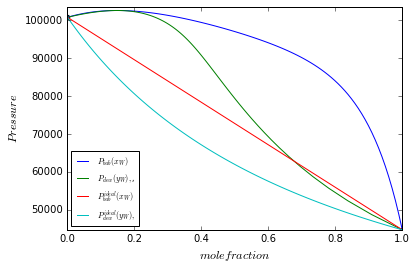

In [134]:
xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = np.array([[xwaxis[i],xa]]).T
    y_, P_axis[i] = Pbol(x_,T)
    ywaxis[i] = y_[0]

plt.figure(1)
plt.plot(xwaxis,P_axis)
plt.plot(ywaxis,P_axis)

pmax = np.max(P_axis)

xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = [xwaxis[i],xa]
    y_, P_axis[i] = Pbol_MisturaIDEAL(x_,T)
    ywaxis[i] = y_[0]

plt.plot(xwaxis,P_axis)
plt.plot(ywaxis,P_axis)

labels = [r'$P_{bub}(x_W)$', r'$P_{dew}(y_W),$,',r'$P^{ideal}_{bub}(x_W)$', r'$P^{ideal}_{dew}(y_W),$']
plt.legend(labels, loc=0)

plt.ylabel(r'$Pressure$')
plt.xlabel(r'$mole fraction$')

plt.scatter([0],[PsatAa])
plt.scatter([1],[PsatAw])

plt.xlim(0,1)
plt.ylim(PsatAw,1.01*pmax)

plt.show()

#min em T aqui: http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BWater.php



C:\Users\iuri\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


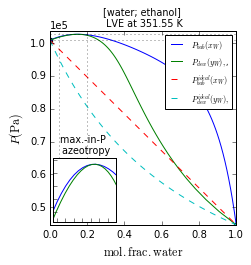

In [265]:
# GRAPHICAL ABSTRACT
%matplotlib inline
from matplotlib import rcParams as rc

fig_width = 9 / 2.54 #in inches
fig_height = 9 / 2.54 #in inches
fig_size =  [fig_width,fig_height]

#FONTS & TICKS\n",
params = {'backend': 'ps',
'axes.labelsize': 12,  #in pts
'font.size': 8, #in pts
'legend.fontsize': 8, #in pts
'xtick.labelsize': 10, #in pts
'ytick.labelsize': 10, #in pts
'text.usetex': False,
'figure.figsize': fig_size}
rc.update(params)

GAfig, GAax1 = plt.subplots(1,1)
xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = np.array([[xwaxis[i],xa]]).T
    y_, P_axis[i] = Pbol(x_,T)
    ywaxis[i] = y_[0]

GAax1.plot(xwaxis,P_axis)
GAax1.plot(ywaxis,P_axis)

pmax = np.max(P_axis)

xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = np.array([[xwaxis[i],xa]]).T
    y_, P_axis[i] = Pbol_MisturaIDEAL(x_,T)
    ywaxis[i] = y_[0]

GAax1.plot(xwaxis,P_axis, ls='--')
GAax1.plot(ywaxis,P_axis, ls='--')


#GAax1.plot([0,.2],[PsatAa,PsatAa],color='k',ls=':')
#GAax1.plot([0,.2],[pmax+.1*(pmax-PsatAa),pmax+.1*(pmax-PsatAa)],color='k',ls=':')
#GAax1.plot([.0,.0],[PsatAa,pmax+.1*(pmax-PsatAa)],color='k',ls=':')
#GAax1.plot([.2,.2],[PsatAa,pmax+.1*(pmax-PsatAa)],color='k',ls=':')

GAax1.plot([0,1],[PsatAa,PsatAa],color='k',ls=':',alpha=.5)
GAax1.plot([0,1],[pmax+.05*(pmax-PsatAa),pmax+.05*(pmax-PsatAa)],color='k',ls=':',alpha=.5)
GAax1.plot([.05,.05],[0,2*pmax],color='k',ls=':',alpha=.5)
GAax1.plot([.2,.2],[0,2*pmax],color='k',ls=':',alpha=.5)

'''
import matplotlib.patches as patches
GAax1.add_patch(
    patches.Rectangle(
        (0, PsatAa),   # (x,y)
        0.2,          # width
        pmax+.1*(pmax-PsatAa) - PsatAa, # height
        alpha=0.25,
        edgecolor="none",
        facecolor="#000000"
    ))
'''


labels = [r'$P_{bub}(x_W)$', r'$P_{dew}(y_W),$,',r'$P^{ideal}_{bub}(x_W)$', r'$P^{ideal}_{dew}(y_W),$']

plt.legend(labels, loc=1)

GAax1.set_title('[water; ethanol] \n LVE at ' + '351.55' + ' K')

GAax1.set_ylabel(r'$P(\mathrm{Pa})$')
GAax1.set_xlabel(r'$\mathrm{mol. frac. water}$')

GAax1.scatter([0],[PsatAa])
GAax1.scatter([1],[PsatAw])

GAax1.set_xlim(0,1)
GAax1.set_ylim(PsatAw,1.01*pmax)

GAfig.subplots_adjust(left=0.17, right=0.9, top=0.9, bottom=0.14)


###

left, bottom, width, height = [0.18, 0.15, 0.25, 0.25]
ax2 = GAfig.add_axes([left, bottom, width, height])

xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = np.array([[xwaxis[i],xa]]).T
    y_, P_axis[i] = Pbol(x_,T)
    ywaxis[i] = y_[0]

ax2.plot(xwaxis,P_axis)
ax2.plot(ywaxis,P_axis)
ax2.set_ylim((PsatAa+pmax)/2,pmax+.05*(pmax-PsatAa))
ax2.set_xlim(0.05,.2)

ax2.set_title('max.-in-P \n azeotropy')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right='off',         # ticks along the top edge are off
    labelleft='off') # labels along the bottom edge are off

plt.setp(ax2.get_yaxis().get_offset_text(), visible=False)


###


GAax1.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))

GAfig.savefig('fig2.png', dpi=1000)

GAfig.show()

#min em T aqui: http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BWater.php

